##### Задание:
Основные цели этого задания:
- попрактиковаться в анализе временных рядов,
- научиться извлекать дополнительные признаки для прогнозирования временного ряда,
- проверять качество модели на отложенной выборке.\
*Задача:* спрогнозировать число пассажиров авиакомпании помесячно.

In [1]:
import pandas as pd
import numpy as np
import io
import zipfile
import calendar

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels import api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["font.size"] = 10
plt.style.use("dark_background")

In [2]:
param_plt = {"marker": "o", "markersize": 6, "linewidth": 2}

#### 1. Загрузите данные из источника по ссылке, ознакомьтесь с ними и подготовьте к аналитике

In [3]:
try:
    archive = zipfile.ZipFile("archive.zip", "r")
    filename = "".join([i.filename for i in archive.filelist])
    txtdata = archive.read(filename)
    df = pd.read_csv(io.BytesIO(txtdata), sep=",")
except FileNotFoundError:
    print("You have to load the file to the directory before opening it.")

In [4]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
df.columns = df.columns.str.replace("#", "").str.lower()
df.columns

Index(['month', 'passengers'], dtype='object')

In [7]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
month,144,144,1949-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passengers,144.0,NaN,NaN,NaN,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


В датасете 2 столбца: object (в нем дата) и числовой.\
144 строки.

1.1. Найдите и удалите пропуски, если они есть.

In [8]:
print("Пропущенных значений:", sum(df.isna().sum()))

Пропущенных значений: 0


1.2. Поменяйте тип столбца с временными отсечками в datetime.

In [9]:
df.month = pd.to_datetime(df.month, format="%Y-%m")

Также поменяем формат данных с пассажирами на занимающий меньшую память.

In [10]:
df.passengers = df.passengers.astype("int16")

1.3. Установите индексом данных столбец с временными отсечками и убедитесь, что он монотонно возрастает.

In [11]:
df.set_index("month", inplace=True)

In [12]:
df.head(2)

,passengers
month,
1949-01-01,112
1949-02-01,118


In [13]:
df.index.is_monotonic_increasing

True

#### 2. Проанализируйте временной ряд

2.1. Оставьте для аналитики лишь с 1952 по 1957 год (включительно).

In [14]:
df_reduced = df["1952":"1957"].copy()

Посмотрим на данные на график со скользящим средним для более ясной визуализации.

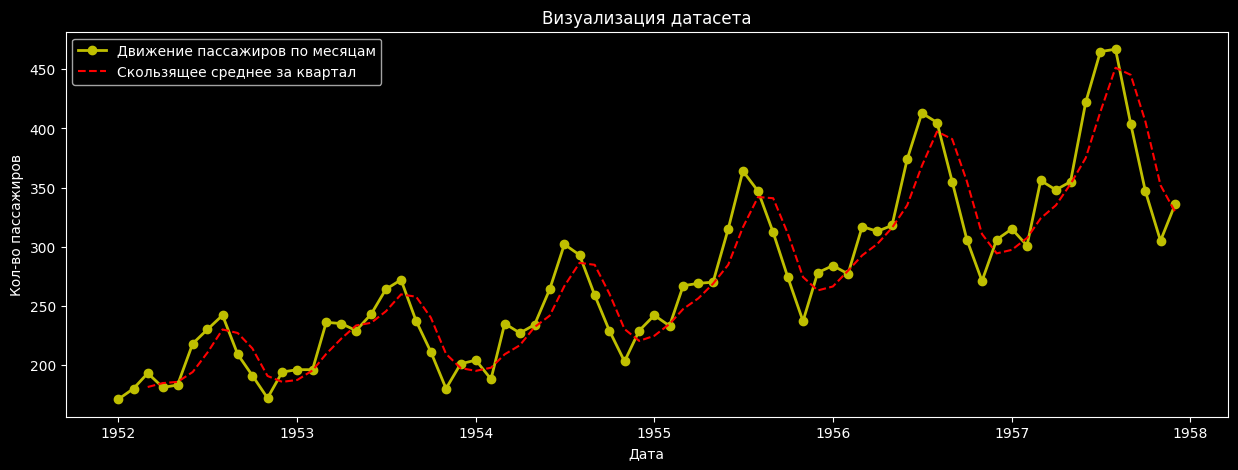

In [15]:
plt.title("Визуализация датасета")
plt.plot(df_reduced, color="y", label="Движение пассажиров по месяцам", **param_plt)
plt.plot(
    df_reduced.rolling(3).mean(),
    linestyle="--",
    label="Скользящее среднее за квартал",
    color="r",
)
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Кол-во пассажиров")
plt.show()

Уже по этому графику видно некий тренд и сезонность.

2.2. Реализуйте разложение на компоненты тренда и сезонности. Визуализируйте результат разложения и сделайте выводы:
- Есть ли тренд?
- Есть ли сезонность и какая она (ежемесячная/ежеквартальная/ежегодная и т.д.)?
- Является ли ряд стационарным и почему?

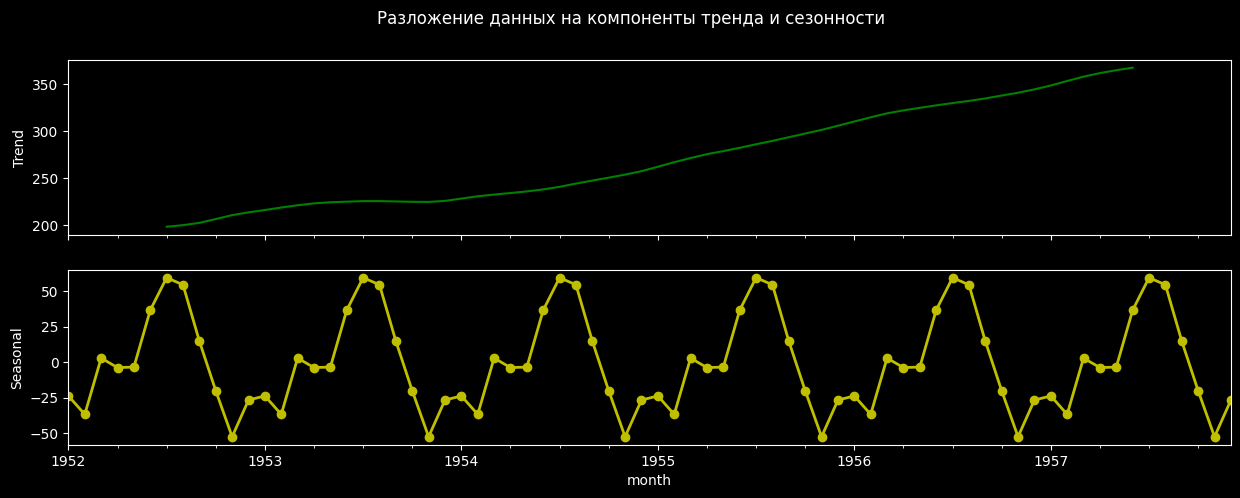

In [16]:
decompose = seasonal_decompose(df_reduced)

fig, axes = plt.subplots(2, 1, sharex=True)
fig.suptitle("Разложение данных на компоненты тренда и сезонности")
decompose.trend.plot(ax=axes[0], legend=False, color="g")
axes[0].set_ylabel("Trend")
decompose.seasonal.plot(ax=axes[1], legend=False, color="y", **param_plt)
axes[1].set_ylabel("Seasonal")
plt.show()

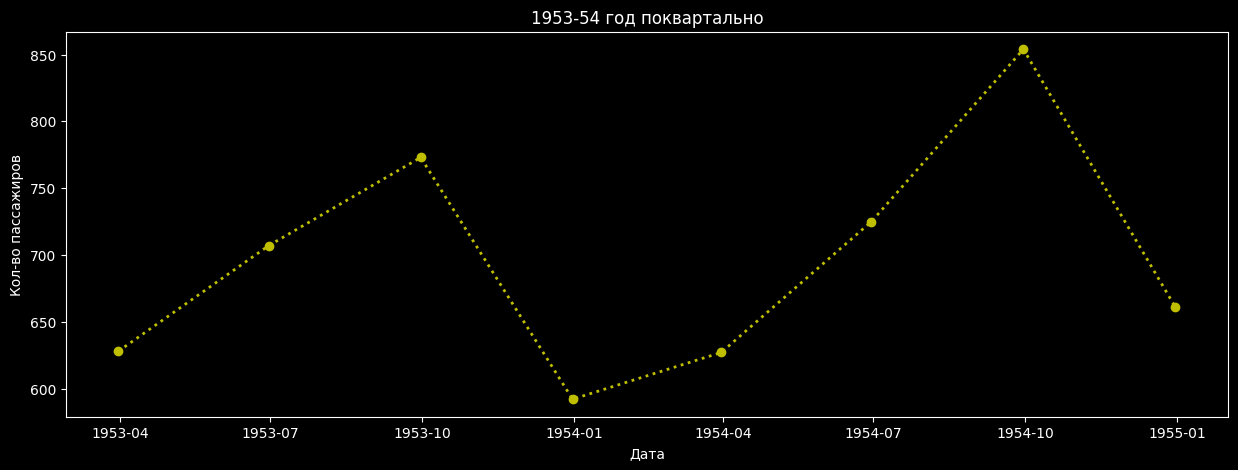

In [17]:
plt.title("1953-54 год поквартально")
plt.plot(
    df_reduced["1953":"1954"].resample("Q", label="right").sum(),
    color="y",
    linestyle="dotted",
    **param_plt
)
plt.xlabel("Дата")
plt.ylabel("Кол-во пассажиров")
plt.show()

Для надежности проведем тест Dickey-Fuller на стационарность.\
Н0: ряд нестационарный\
Н1: ряд стационарный

In [18]:
ad_fuller_result = adfuller(df_reduced.passengers)
p_value = ad_fuller_result[1]
print(f"ADF Statistic: {round(ad_fuller_result[0], 4)}, p-value: {round(p_value, 4)}")

alpha = 0.05

if p_value < alpha:
    print("Ряд стационарный (отклоняем H0)")
else:
    print("Ряд нестационарный (подтверждается H0)")

ADF Statistic: 0.8585, p-value: 0.9925
Ряд нестационарный (подтверждается H0)


Тренд временного ряда появляется с 1954 года, тренд идет на увеличение.\
Также видно сезонную повторяемость: рост с весны до конца сентября (сезон отпусков), и падение к концу года.
Ряд не является стационарным, так как у него есть тренд на увеличение и есть сезонность.\
Тест Dickey-Fuller показал  p-value = 99.25, что тоже подтверждает нестационарность.

2.3. Постройте график, чтобы оценить автокорреляцию и сделайте выводы:
- У какого сдвига самая высокая автокорреляция?
- Подтверждаются ли выводы о наличии тренда графиком автокорреляции?

In [19]:
acf = sm.tsa.acf(df_reduced.passengers)
acf

array([1.        , 0.89400793, 0.74549489, 0.61531598, 0.50234066,
       0.43030094, 0.38667   , 0.35354755, 0.35686359, 0.40011587,
       0.4555686 , 0.53720175, 0.58170785, 0.49625454, 0.37523856,
       0.27647025, 0.19148319, 0.13560224, 0.09421318])

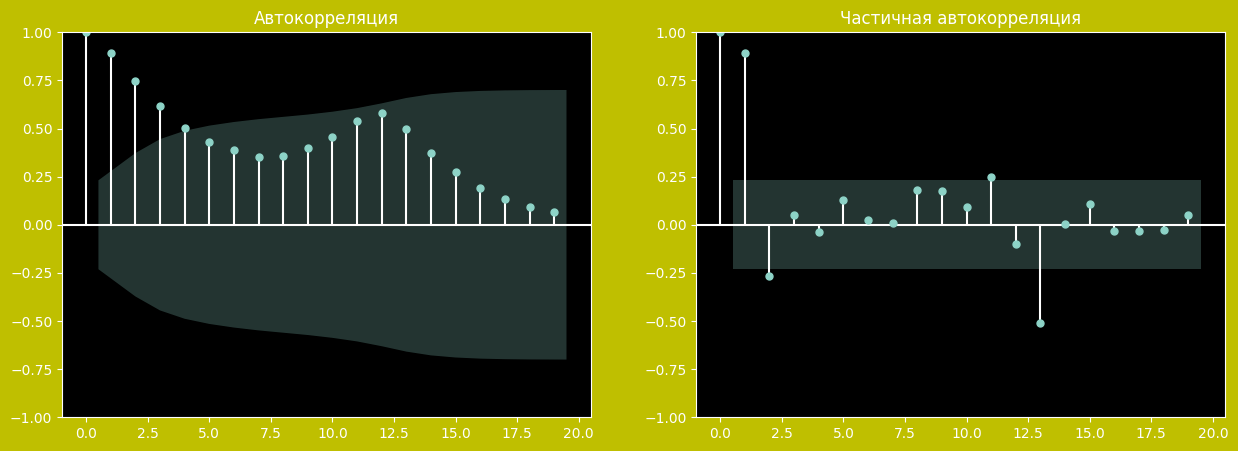

In [20]:
fig, ax = plt.subplots(1, 2)
fig = tsaplots.plot_acf(df_reduced.passengers, title="Автокорреляция", ax=ax[0])
fig = tsaplots.plot_pacf(
    df_reduced.passengers, title="Частичная автокорреляция", ax=ax[1]
)
fig.set_facecolor("y")
plt.show()

Самая высокая автокорреляция при сдвиге на 1 месяц, что логично, так как мы наблюдаем постоянный тренд,\
а также на 2-3 месяца.\
Все значения положительные -> тренд роста постоянный.\
Также видно сезонность при лаге на 12.\
Частичная автокорреляция высока при сдвиге на 1, 2, 11, 13.

#### 4. Подготовьте данные к обучению линейной модели

4.1. Напишите функцию, которая будет генерировать новые признаки (календарные признаки, несколько колонок с разными сдвигами, несколько колонок с разными скользящими средними)
- Добавьте аргумент, который будет отвечать за возможные сдвиги. Это должен быть список, по которому в цикле будет добавляться новая колонка lag_n, где n — число из этого списка, отвечающее за сдвиг.
- Добавьте аргумент, который будет отвечать за возможные размеры скользящего среднего. Это должен быть список, по которому в цикле будет добавляться новая колонка rolling_mean_m, где m — число из этого списка, отвечающее за размер окна, по которому вычисляется среднее. Не забудьте, что скользящее среднее нужно сдвигать, чтобы не было «заглядывания в будущее».

In [21]:
def features_generator(df, n, m):
    # календарные признаки
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["Q"] = df.index.quarter
    df["is_leap"] = df.year.apply(lambda x: calendar.isleap(x))
    # несколько колонок с разными сдвигами
    for lag in n:
        df[f"lag_{lag}"] = df.passengers.shift(lag)
    # несколько колонок с разными скользящими средними
    for roll in m:
        df[f"rolling_mean_{roll}"] = df.passengers.rolling(roll).mean().shift(1)
    return df

4.2 Рассчитайте новые признаки с помощью реализованной функции, подав ей на вход произвольные параметры генерации новых признаков.

In [22]:
df_new_feat = features_generator(df_reduced.copy(), [1, 3, 12], [2, 9, 11, 13])

In [23]:
df_new_feat.head(3)

,passengers,month,year,Q,is_leap,lag_1,lag_3,lag_12,rolling_mean_2,rolling_mean_9,rolling_mean_11,rolling_mean_13
month,,,,,,,,,,,,
1952-01-01,171,1,1952,1,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952-02-01,180,2,1952,1,True,171.0,NaN,NaN,NaN,NaN,NaN,NaN
1952-03-01,193,3,1952,1,True,180.0,NaN,NaN,175.5,NaN,NaN,NaN


4.3. Удалите наблюдения с пропусками в новых переменных.

In [24]:
df_new_feat.dropna(inplace=True)

4.4. Разделите данные на признаки и целевую переменную.

In [25]:
y = df_new_feat.passengers
X = df_new_feat.drop(["passengers"], axis=1)

4.5. Разделите данные на обучающую и валидационную части. Не забудьте, что валидационная часть должна идти строго после обучающей.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

#### 5.Обучите линейную модель машинного обучения и оцените ее качество.

5.1. Обучите линейную модель на обучающей части данных.

In [28]:
model = LinearRegression()
model.fit(X_train_sc, y_train)

LinearRegression()

5.2. Рассчитайте значение метрики качества MAE на обучающей и валидационных частях. Если модель работает плохо (метрика выше 20), попробуйте выделить другой набор признаков, вызывая свою функцию с новыми параметрами.

In [29]:
y_pred_train = pd.Series(model.predict(X_train_sc))
y_pred_train.index = X_train.index
y_pred_test = pd.Series(model.predict(X_test_sc))
y_pred_test.index = X_test.index

print("MAE обучающей выборки:", mean_absolute_error(y_train, y_pred_train))
print("MAE тестовой выборки: ", mean_absolute_error(y_test, y_pred_test))

MAE обучающей выборки: 7.01344636551773
MAE тестовой выборки:  5.9235670690836555


In [30]:
pd.DataFrame(
    zip(X_train.columns, (abs(model.coef_))), columns=["feature", "importance"]
).sort_values(by="importance", ascending=False)[:10]

,feature,importance
10,rolling_mean_13,368.048434
9,rolling_mean_11,325.118770
6,lag_12,75.180681
4,lag_1,55.278802
8,rolling_mean_9,15.995233
7,rolling_mean_2,12.900693
0,month,10.956916
1,year,10.430527
2,Q,8.471408
5,lag_3,4.114172


Выбранные моделью признаки практически совпадают с выбранными на основе ACF/PACF.

5.3. Визуализируйте реальный временной ряд и прогнозные значения. 

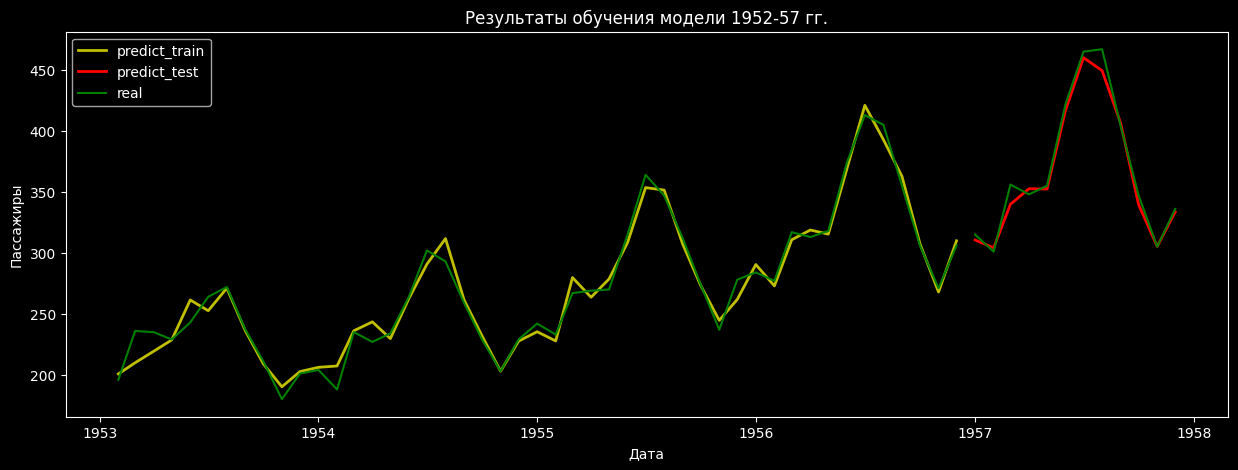

In [31]:
plt.plot(y_pred_train, label="predict_train", color="y", linewidth=2)
plt.plot(y_pred_test, label="predict_test", color="red", linewidth=2)
plt.plot(y_test, label="real", color="g")
plt.plot(y_train, color="g")

plt.title("Результаты обучения модели 1952-57 гг.")
plt.ylabel("Пассажиры")
plt.xlabel("Дата")

plt.legend()
plt.show()

На графике видно, что полученный результат достаточно близок к реальному, только в некоторых местах ошибка увеличивается.

#### 6.Оцените качество модели на отложенной выборке. В качестве отложенной выборки у нас будут наблюдения с 1958 по 1960 год.

6.1. Возьмите из источника необходимый срез данных.

In [32]:
df_reduced = df["1957":"1960"].copy()
df_reduced.shape

(48, 1)

6.2. Подготовьте данные к прогнозированию:
- Добавьте признаки с помощью реализованной ранее функции.
- Удалите наблюдения с пропусками.
- Если после удаления у вас осталось менее 36 наблюдений, откорректируйте срез из пункта 5.а.
- Отделите целевую переменную от признаков.

In [33]:
df_new_feat = features_generator(df_reduced.copy(), [1, 3, 12], [2, 9, 11, 13])
df_new_feat.head()

,passengers,month,year,Q,is_leap,lag_1,lag_3,lag_12,rolling_mean_2,rolling_mean_9,rolling_mean_11,rolling_mean_13
month,,,,,,,,,,,,
1957-01-01,315,1,1957,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-02-01,301,2,1957,1,False,315.0,NaN,NaN,NaN,NaN,NaN,NaN
1957-03-01,356,3,1957,1,False,301.0,NaN,NaN,308.0,NaN,NaN,NaN
1957-04-01,348,4,1957,2,False,356.0,315.0,NaN,328.5,NaN,NaN,NaN
1957-05-01,355,5,1957,2,False,348.0,301.0,NaN,352.0,NaN,NaN,NaN


In [34]:
df_new_feat.dropna(inplace=True)
df_new_feat.shape

(35, 12)

In [35]:
y_val = df_new_feat.passengers
X_val = df_new_feat.drop(["passengers"], axis=1)

In [36]:
X_val_sc = scaler.transform(X_val)

6.3. Постройте прогноз с помощью обученной ранее линейной модели.

In [37]:
y_pred_val = pd.Series(model.predict(X_val_sc))
y_pred_val.index = X_val.index

6.4. Рассчитайте значение метрики качества на отложенной выборке.

In [38]:
print("MAE отложенной выборки:", mean_absolute_error(y_val, y_pred_val))

MAE отложенной выборки: 12.69650778297166


6.5. Визуализируйте реальный временной ряд и прогнозные значения.

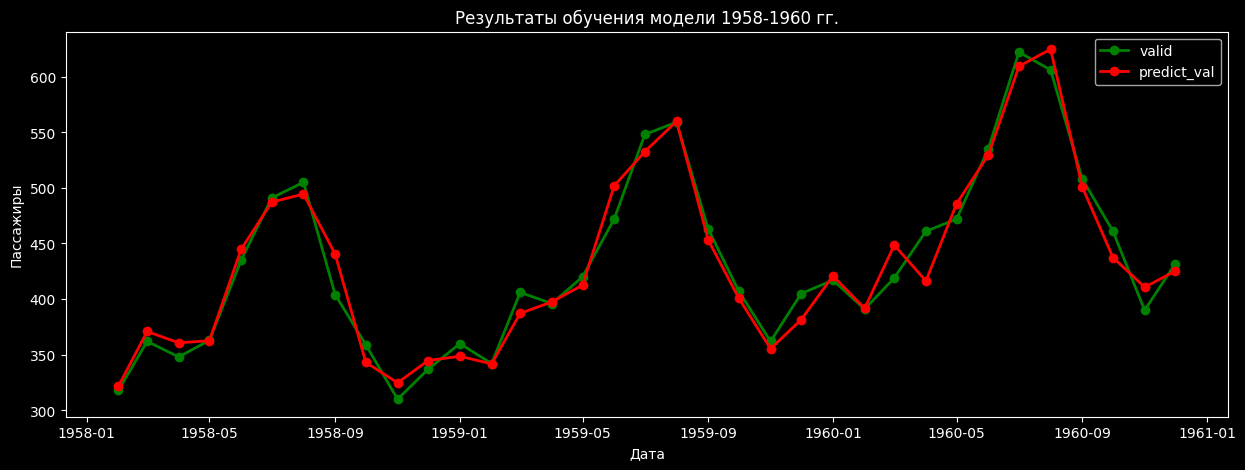

In [39]:
plt.plot(y_val, label="valid", color="g", **param_plt)
plt.plot(y_pred_val, label="predict_val", color="r", **param_plt)

plt.title("Результаты обучения модели 1958-1960 гг.")
plt.ylabel("Пассажиры")
plt.xlabel("Дата")

plt.legend()
plt.show()

6.6. Значение метрики MAE на отложенной выборке должно быть не более 35.